In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving build_vocab.py to build_vocab.py
Saving decoder-5-3000.pkl to decoder-5-3000.pkl
Saving encoder-5-3000.pkl to encoder-5-3000.pkl
Saving model.py to model.py
Saving vocab.pkl to vocab.pkl
User uploaded file "build_vocab.py" with length 2534 bytes
User uploaded file "decoder-5-3000.pkl" with length 36933387 bytes
User uploaded file "encoder-5-3000.pkl" with length 235372830 bytes
User uploaded file "model.py" with length 2773 bytes
User uploaded file "vocab.pkl" with length 360187 bytes


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Function to Load and Resize the image
def load_image(image_path, transform=None): 
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
      image = transform(image).unsqueeze(0)
    return image

In [0]:
# MODEL DIRS
ENCODER_PATH = 'encoder-5-3000.pkl'
DECODER_PATH = 'decoder-5-3000.pkl'
VOCAB_PATH = 'vocab.pkl'

# CONSTANTS
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1

In [0]:
def PretrainedResNet(image_path, encoder_path=ENCODER_PATH, 
                     decoder_path=DECODER_PATH,
                     vocab_path=VOCAB_PATH,
                     embed_size=EMBED_SIZE,
                     hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
# Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)
# Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))
# Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    # Generate a caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)[8:-5].title() 
    # Print out the image and the generated caption
    image = Image.open(image_path)
    return sentence, image

A Group Of People In A Room With A Man And A Woman . 


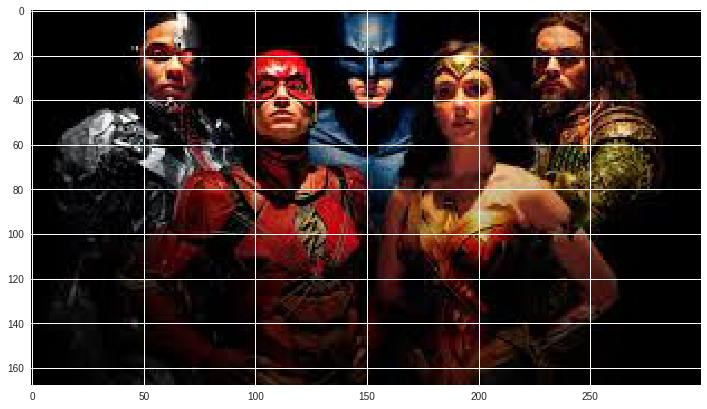

In [20]:
plt.figure(figsize=(12,12))
predicted_label, image = PretrainedResNet(image_path='jl.jpg')
plt.imshow(image)
print(predicted_label)

In [19]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving jl.jpg to jl.jpg
User uploaded file "jl.jpg" with length 8670 bytes
